<a href="https://colab.research.google.com/github/kevinash/awesome-ai/blob/main/notebooks/6_PosesAndAction/DetectingHumanBodyKeypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Human Body Keypoints

Book [Awesome AI: Make Art with Artificial Intelligence](http://kevinashley.com).

In addition, check this deep dive video course [AI in Sports with Python](http://activefitness.ai/ai-in-sports-with-python).



In [1]:
import torch
from torchvision import models

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=Tr

Saving 396999001.jpg to 396999001.jpg
User uploaded file "396999001.jpg" with length 153789 bytes


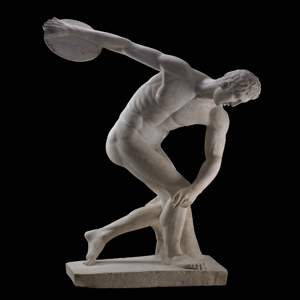

In [11]:
#@title Upload content image

import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os
%matplotlib inline

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
content_img = "content." + fn.split(".")[-1]
!mv -f $fn $content_img

img = Image.open(content_img)
(width, height) = img.size
content_img_max = max(width, height)
content_img_min = min(width, height)

img = Image.open(content_img).resize((300, 300))
display(Image.open(content_img).resize((300, 300)))

In [12]:
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)



img_tensor = normalize(img)
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[  0.0000,  10.9471, 196.7360, 224.0000],
         [105.0230,  52.5316, 224.0000, 224.0000]], grad_fn=<StackBackward>),
 'keypoints': tensor([[[119.6368, 151.9092,   1.0000],
          [122.9950, 151.3492,   1.0000],
          [125.2338, 151.9092,   1.0000],
          [115.9987, 113.2741,   1.0000],
          [ 94.7299,  76.0388,   1.0000],
          [ 70.1029,  11.6470,   1.0000],
          [  0.6996,  11.6470,   1.0000],
          [136.9876, 147.7097,   1.0000],
          [ 46.3155, 190.2643,   1.0000],
          [125.5137, 155.8287,   1.0000],
          [123.5547, 158.9083,   1.0000],
          [137.5473,  51.9618,   1.0000],
          [ 91.9314, 105.4351,   1.0000],
          [168.8907, 135.1113,   1.0000],
          [144.8235, 151.6292,   1.0000],
          [ 44.3566, 193.0639,   1.0000],
          [112.9203, 181.3054,   1.0000]],
 
         [[124.1993,  74.4896,   1.0000],
          [134.5573,  62.4617,   1.0000],
          [120.2801,  71.1330,   1.0000],
      

In [13]:
def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)


In [14]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [233, 103, 1], "left_eye": [239, 102, 1], "right_eye": [234, 97, 1], "left_ear": [237, 105, 1], "right_ear": [229, 81, 1], "left_shoulder": [215, 115, 1], "right_shoulder": [186, 72, 1], "left_elbow": [215, 160, 1], "right_elbow": [129, 46, 1], "left_wrist": [194, 191, 1], "right_wrist": [87, 34, 1], "left_hip": [120, 148, 1], "right_hip": [124, 139, 1], "left_knee": [176, 197, 1], "right_knee": [179, 192, 1], "left_ankle": [102, 234, 1], "right_ankle": [102, 234, 1]}]'

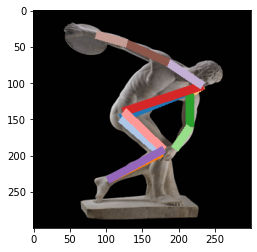

In [15]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)
        
def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)
    
def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)
    plt.show()

draw_stickman(img, json_keypoints)